# Empréstimo Pessoal (Thera Bank)

**Este projeto analisa o caso do Thera Bank, uma instituição financeira que busca aumentar a conversão de seus clientes de depósito (passivos) em clientes de empréstimos pessoais. Em uma campanha anterior, o banco obteve uma taxa de conversão de aproximadamente 9%, considerada positiva pela administração. Esse resultado motivou o departamento de marketing de varejo a investir em estratégias de marketing mais direcionado, com o objetivo de elevar a taxa de sucesso e, ao mesmo tempo, otimizar os custos da campanha.**

**Caso Hipotético**

O investimento em marketing direcionado pelo banco foi de $10,000. Para cada cliente que será enviado uma oferta existe um custo fixo de $100, caso o cliente aceite a oferta o retorno estimado é de $500 por cliente.

obs.: Estes valores devem ser extraídos juntamente com uma equipe especializada com entendimento do negócio.

## EDA- Exploração e Análise dos Dados

### Importação das bibliotecas e carregamento dos dados para o workspace

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [150]:
# Ganho de Informação
from sklearn.feature_selection import mutual_info_classif

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Pré-Processamento
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

# Oversampling e Undersampling
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Métricas
from sklearn.metrics import confusion_matrix, make_scorer

In [151]:
sns.set_theme(style='darkgrid', palette=None)
warnings.filterwarnings('ignore')

In [152]:
path_data = 'Files/Bank_Personal_Loan_Data.csv'
data = pd.read_csv(path_data)

In [153]:
data.head(10)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1
5,6,37,13,29,92121,4,0/40,2,155,0,0,0,1,0
6,7,53,27,72,91711,2,1/50,2,0,0,0,0,1,0
7,8,50,24,22,93943,1,0/30,3,0,0,0,0,0,1
8,9,35,10,81,90089,3,0/60,2,104,0,0,0,1,0
9,10,34,9,180,93023,1,8/90,3,0,1,0,0,0,0


### Verificação da consistência dos dados

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  5000 non-null   int64 
 1   Age                 5000 non-null   int64 
 2   Experience          5000 non-null   int64 
 3   Income              5000 non-null   int64 
 4   ZIP Code            5000 non-null   int64 
 5   Family              5000 non-null   int64 
 6   CCAvg               5000 non-null   object
 7   Education           5000 non-null   int64 
 8   Mortgage            5000 non-null   int64 
 9   Personal Loan       5000 non-null   int64 
 10  Securities Account  5000 non-null   int64 
 11  CD Account          5000 non-null   int64 
 12  Online              5000 non-null   int64 
 13  CreditCard          5000 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 547.0+ KB


In [155]:
print(f'Quantidade de células nulas por coluna \n{data.isna().sum()}')

Quantidade de células nulas por coluna 
ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


In [156]:
print(f'Quantidade de registros duplicados: {int(data.duplicated().sum())}')

Quantidade de registros duplicados: 0


In [157]:
data.describe()

,ID,Age,Experience,Income,ZIP Code,Family,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


A coluna ID é um campo de identificação e não traz informação para prever a variável alvo, logo será removida do dataset

In [158]:
data.drop('ID', axis=1, inplace=True)

Observamos que alguns registros apresentam valores negativos na coluna 'Experience' (anos de experiência). Será necessário avaliar se esses valores representam erros de digitação ou informações inconsistentes. Para isso, analisaremos a relação dessa variável com as demais features e verificaremos se os valores negativos seguem algum padrão específico antes de decidir se devem ser removidos ou corrigidos.

In [159]:
data_filter = data[data['Experience']<0]

print(f'Quantidade de registros com experiência negativa: {len(data_filter)}')
data_filter.head()

Quantidade de registros com experiência negativa: 52


,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
89,25,-1,113,94303,4,2/30,3,0,0,0,0,0,1
226,24,-1,39,94085,2,1/70,2,0,0,0,0,0,0
315,24,-2,51,90630,3,0/30,3,0,0,0,0,1,0
451,28,-2,48,94132,2,1/75,3,89,0,0,0,1,0
524,24,-1,75,93014,4,0/20,1,0,0,0,0,1,0


O campo CCAvg representa a média de gastos mensais no cartão de crédito (em milhares de dólares). Originalmente, os valores estavam em uma notação textual confusa, como 1/70, que corresponde a 1.70 × 1000 dólares. Para facilitar a análise, os valores foram convertidos substituindo o caractere / por . e transformados em números decimais (float64), mantendo a unidade em milhares de dólares.

In [160]:
data['CCAvg'] = data['CCAvg'].str.replace('/','.').astype(float)
data['CCAvg'] = data['CCAvg']*1000

O campo Mortgage corresponde ao valor do financiamento da casa de um cliente em milhares de dólars, vou normalizar para o valor literal em dólares.

In [161]:
data['Mortgage'] = data['Mortgage']*1000

Nossos dados agora se organizam da seguinte maneira

Conteúdo das Colunas

| Coluna                 | Descrição                                                                |
|------------------------|--------------------------------------------------------------------------|
| ID                     | ID do cliente                                                            |
| Age                    | Idade do cliente (em anos completos)                                     |
| Experience             | Anos de experiência profissional                                         |
| Income                 | Renda anual do cliente                                                   |
| ZIP Code               | Código postal do endereço                                                |
| Family                 | Tamanho da família do cliente                                            |
| CCAvg                  | Média de gastos mensais no cartão de crédito                             |
| Education              | Nível educacional (1 = graduação, 2 = pós-graduação, 3 = avançado)       |
| Mortgage               | Valor do financiamento da casa, se houver                                |
| Personal Loan          | Cliente aceitou o empréstimo pessoal oferecido na última campanha?       |
| Securities Account     | Cliente possui conta de valores mobiliários no banco?                    |
| CD Account             | Cliente possui conta de certificado de depósito (CD) no banco?           |
| Online                 | Cliente utiliza serviços de internet banking?                            |
| CreditCard             | Cliente possui cartão de crédito emitido pelo banco UniversalBank?       |



In [162]:
data.head(10)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1600.0,1,0,0,1,0,0,0
1,45,19,34,90089,3,1500.0,1,0,0,1,0,0,0
2,39,15,11,94720,1,1000.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2700.0,2,0,0,0,0,0,0
4,35,8,45,91330,4,1000.0,2,0,0,0,0,0,1
5,37,13,29,92121,4,400.0,2,155000,0,0,0,1,0
6,53,27,72,91711,2,1500.0,2,0,0,0,0,1,0
7,50,24,22,93943,1,300.0,3,0,0,0,0,0,1
8,35,10,81,90089,3,600.0,2,104000,0,0,0,1,0
9,34,9,180,93023,1,8900.0,3,0,1,0,0,0,0


In [163]:
target_feature = ["Personal Loan"]
id_features = ["ID", "ZIP Code"]
numeric_features = ["Age", "Experience", "Income", "CCAvg", ]
categorical_features = ["Family", "Education", "Securities Account", "CD Account", "Online", "CreditCard"]

### Distribuição dos dados

Recusaram 4520 - Aceitaram 480


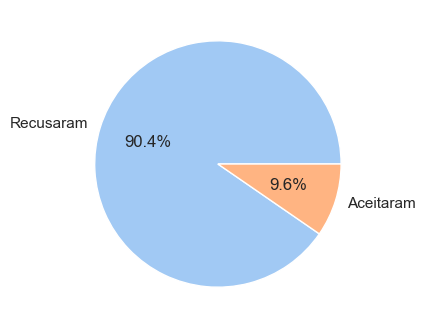

In [164]:
counts = data[target_feature].value_counts()
labels = ["Recusaram", "Aceitaram"]
sizes = counts.values

print(labels[0], sizes[0], '-', labels[1], sizes[1])

plt.figure(figsize=(4,4))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=sns.color_palette("pastel"))
plt.show()


Os dados são desbalanceados, sendo 4520 registros para a classe negativa (90.4%) e 480 registros para a classe positiva (9.6%)

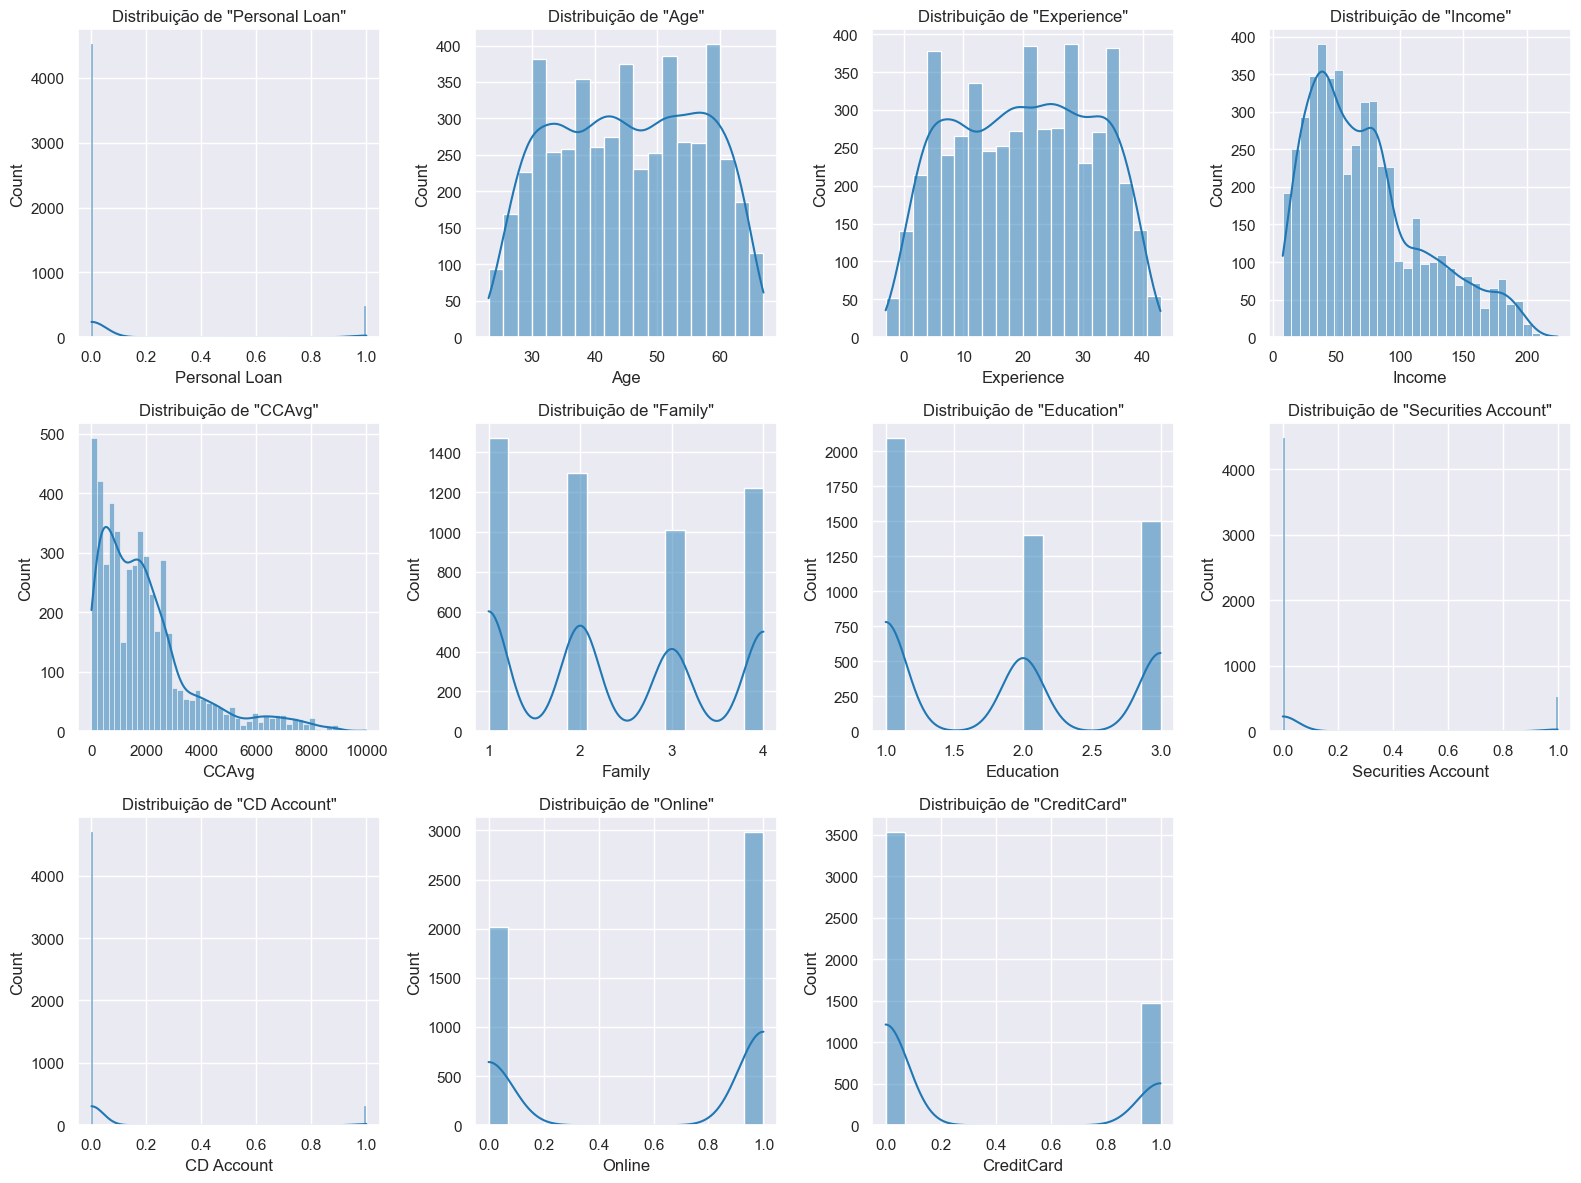

In [165]:
features_analized = target_feature + numeric_features + categorical_features
ncols = 4
nrows = len(features_analized)//ncols+1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()

for i, feature in enumerate(features_analized):
    sns.histplot(x=data[feature], ax=axs[i], kde=True)
    axs[i].set_title(f"Distribuição de \"{feature}\"")

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
    

### Outliers

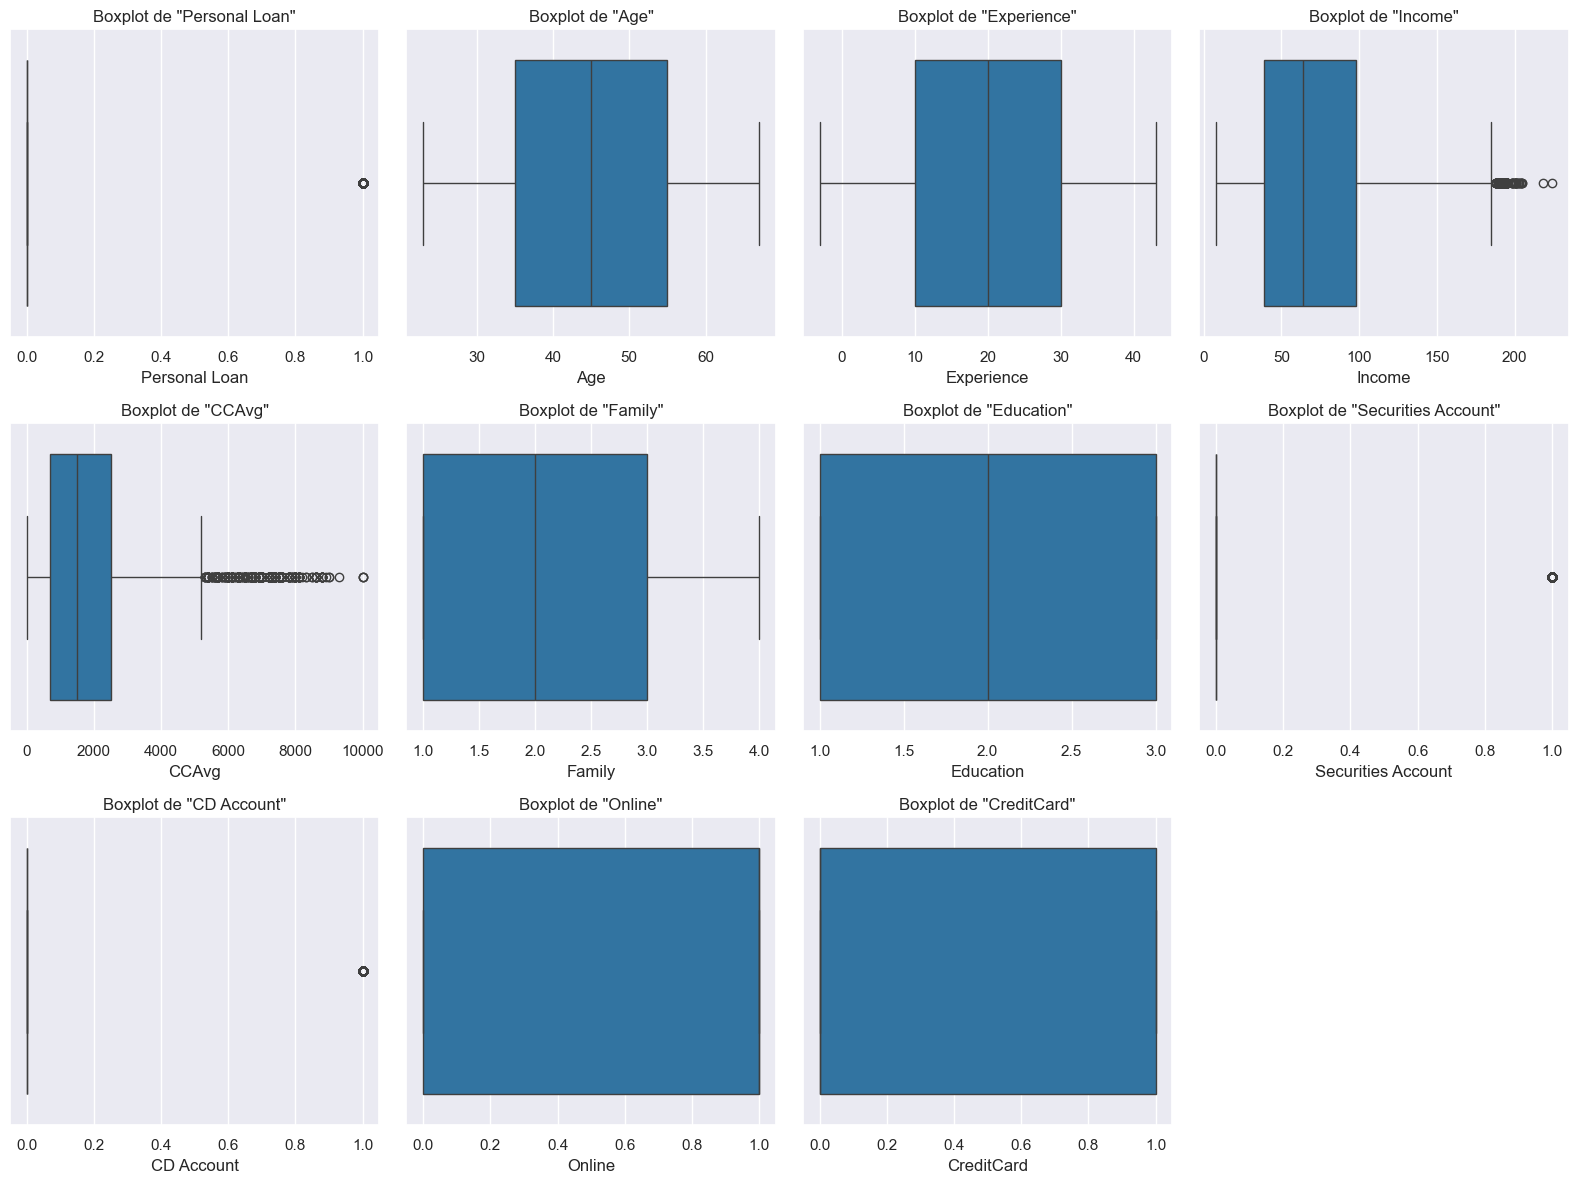

In [166]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
axs = axs.flatten()

for i, feature in enumerate(features_analized):
    sns.boxplot(x=data[feature], ax=axs[i])
    axs[i].set_title(f"Boxplot de \"{feature}\"")

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
    

### Análise de correlação

- As variáveis "Experience" e "Age" tem uma relação muito forte (ρ=0.99), ou seja, são variáveis redundantes. Podemos remover uma delas sem perca de informação relevante.
- "CCAvg" e "Income" tem ρ=0.65, indicando um comportamento semelhante entre a média de gastos mensais no cartão e a renda do cliente. É de se esperar que quanto mais alguém ganha, mais ele gasta.
- "Personal Loan" (nossa variável alvo) e "Income" tem ρ=0.5, dando indícios de que a variável "Income" será muito importante para a predição de interesse, bem como CCAvg com ρ=0.37

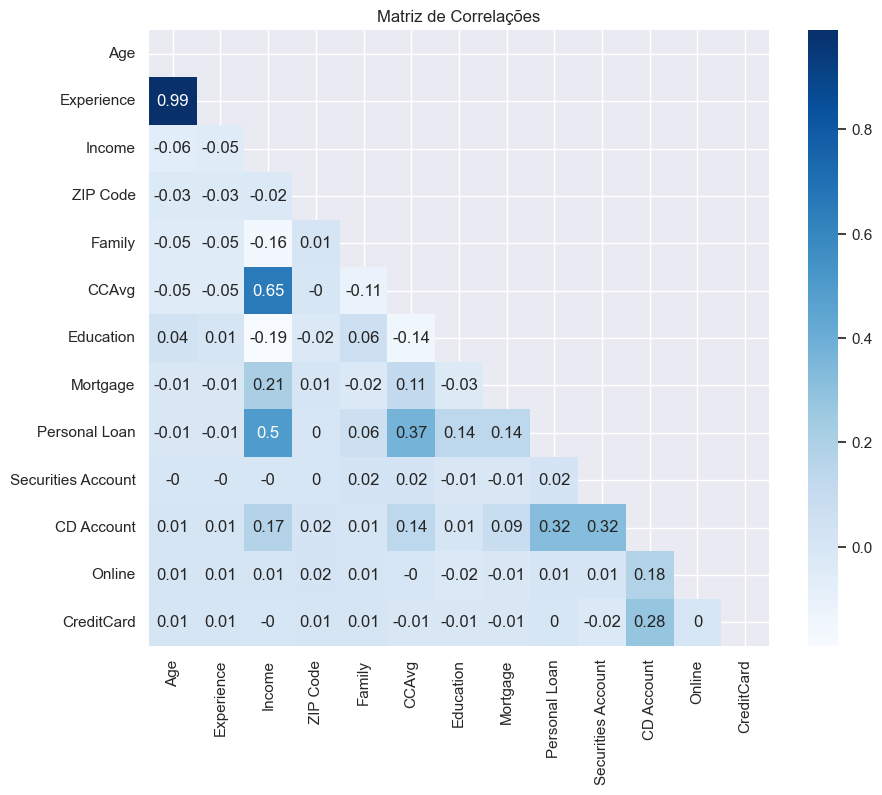

In [167]:
corr_matrix = data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10,8))
sns.heatmap(round(corr_matrix,2), mask=mask, cmap='Blues', annot=True)
plt.title('Matriz de Correlações')
plt.show()

### Relação das variáveis numéricas com a variável alvo 

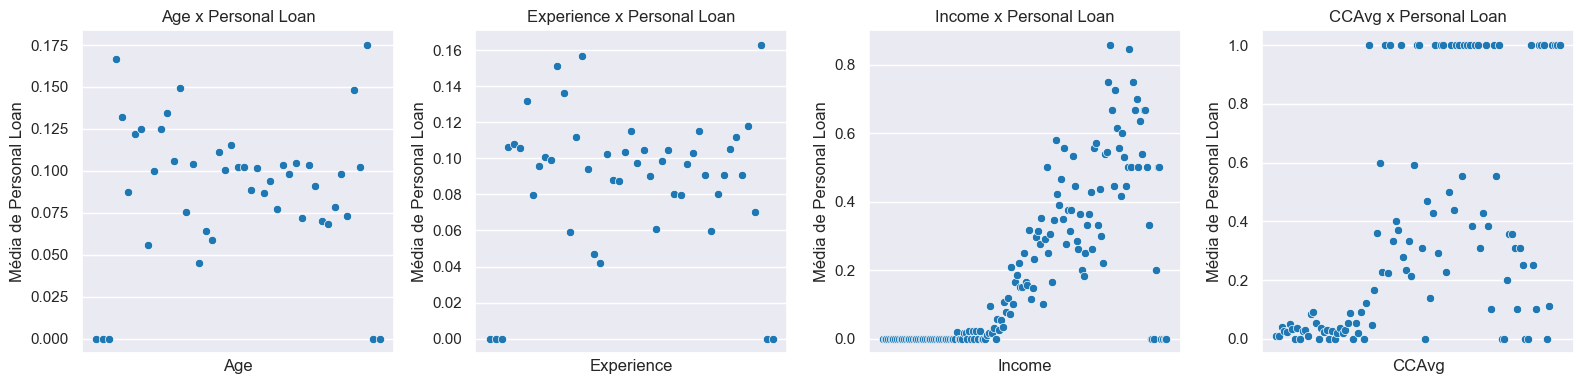

In [168]:
fig, axs = plt.subplots(nrows=1, ncols=len(numeric_features), figsize=(4*len(numeric_features), 4))
axs = axs.flatten()

for i, feature in enumerate(numeric_features):
    relation = data.groupby(feature)[target_feature[0]].mean()

    sns.scatterplot(x=relation.index.astype(str), y=relation.values, ax=axs[i])
    axs[i].set_title(f'{feature} x {target_feature[0]}')
    axs[i].set_xlabel(feature)
    axs[i].set_xticks([])
    axs[i].set_ylabel(f'Média de {target_feature[0]}')

plt.tight_layout()
plt.show()

Avaliando a relação das variáveis, conseguimos extrair alguns padrões.

- "Age" e "Experience", como vimos antes tem correlação (ρ=0.99), logo a distribuição e ganho de informação destas variáveis são semelhantes. O gráfico mostra que essas variáveis não seguem um padrão explicíto, ou seja, é possível que estas variáveis não apresentam valor preditivo considerável.
- "Income" e "CCAvg" são variáveis muito informativas para a nossa variável alvo, como visto na matriz de correlações e no gráfico de pontos.

### Relação das variáveis categóricas com a variável alvo 

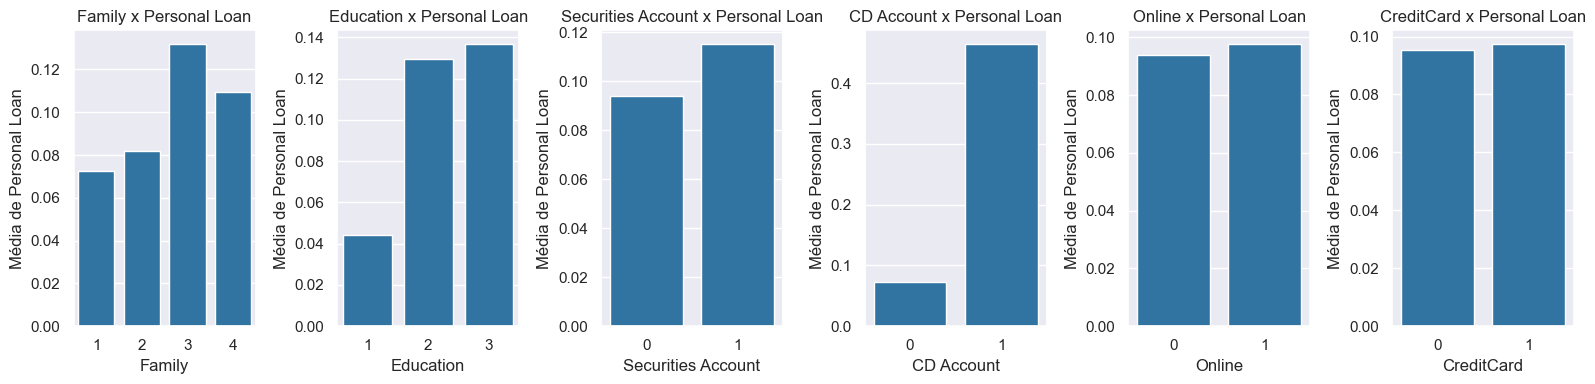

In [169]:
fig, axs = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(4*len(numeric_features), 4))
axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    relation = data.groupby(feature)[target_feature[0]].mean()

    sns.barplot(x=relation.index.astype(str), y=relation.values, ax=axs[i])
    axs[i].set_title(f'{feature} x {target_feature[0]}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel(f'Média de {target_feature[0]}')

plt.tight_layout()
plt.show()

Perfil de pessoas mais propícias a aceitar a oferta

- Famílias com 3 membros
- Pessoas com nível educacional avançada / pós graduadas
- Possui conta de valores mobiliários no banco
- Possui certificado de depósito no banco

Analisando mais afundo o ganho de informação, podemos extrair alguns padrões

- As variáveis "Online" e "CreditCard", que indicam o uso de ferramentas na internet do banco e se ela possui cartão de crédito emitido pelo Banco Universal, respectivamente, não apresentam diferenças significativas entre aceitos e não aceitos da proposta.
- A variável "CD Account", que indica se a pessoa possui certificado de depósito no banco tem um ganho de informação relevante, onde cerca de 47% das pessoas que possuem o certificado e 8% que não possuem, aceitaram a proposta.
- "Family" e "Education" que são a quantidade de membros na família e nível educacional tem algum ganho de informação.


### Ganho de Informação

In [170]:
features = numeric_features + categorical_features
x = pd.get_dummies(data[features])
y = data[target_feature[0]]

mi = mutual_info_classif(x, y, discrete_features='auto')

mi_data = pd.DataFrame({
    "Feature": x.columns,
    "Mutual Information" : mi
}).sort_values("Mutual Information", ascending=False)

print(mi_data)

              Feature  Mutual Information
2              Income            0.136026
3               CCAvg            0.095050
7          CD Account            0.027266
4              Family            0.011755
0                 Age            0.009080
5           Education            0.008253
1          Experience            0.004829
6  Securities Account            0.000000
8              Online            0.000000
9          CreditCard            0.000000


Como esperado, temos renda atual por ano, gasto no cartão de crédito e se possui certificado de depósito no banco como principais variáveis informativas para determinar o público alvo.

## Avaliação do negócio

Relembrando nosso problema de negócio. 

**"O investimento em marketing direcionado pelo banco foi de $10,000. Para cada cliente que será enviado uma oferta existe um custo fixo de $100"**


Para definir o melhor modelo de previsão dos clientes, oque gera mais lucro (ou menos custo), utilizamos a **matriz de confusão** para definir. Essa matriz possui a seguinte estrutura:

|                         | **Valor Real (0) - Recusaram** | **Valor Real (1) - Aceitaram** |
|-------------------------|----------------------------|----------------------------|
| **Valor Predito (0) - Recusaram** | **TN** (True Negative)       | **FN** (False Negative)    |
| **Valor Predito (1) - Aceitaram** | **FP** (False Positive)      | **TP** (True Positive)     |

- **TN (True Negative)**: Cliente predito como recusou e realmente recusou
- **FN (False Negative)**: Cliente predito como recusou, mas na verdade aceitou
- **FP (False Positive)**: Cliente predito como aceitou, mas na verdade recusou
- **TP (True Positive)**: Cliente predito como aceitou e realmente aceitou


O lucro total esperado segue a fórmula:

**Lucro = (TP × G) − ((TP + FP) × C)**

- TP × G = lucro obtido com os clientes que aceitaram a oferta.
- (TP + FP) × C = custo de envio da oferta para todos os clientes preditos como aceitação, incluindo os que não aceitaram (FP).
- FN = perda de oportunidade (cliente aceitaria, mas não recebeu a oferta), não gera custo, mas reduz lucro potencial.
- TN - cliente recusaria e não foi enviado a oferta, não há custo nem lucro.

In [171]:
def profit_function(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]

    G = 500
    C = 100

    return (TP*G) - ((TP + FP)*C)

## Modelos Preditivos

Pré processamento dos dados, normalizando e utilizando encodes

In [172]:
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

samplers = {
    "NoSampling": FunctionSampler(func=lambda X, y: (X, y)),
    "SMOTE": SMOTE(random_state=0),
    "RandomOver": RandomOverSampler(random_state=0),
    "RandomUnder": RandomUnderSampler(random_state=0),
    "SMOTEENN": SMOTEENN(random_state=0),
    "SMOTETomek": SMOTETomek(random_state=0)
}

models = {
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0),
    "GaussianNB": GaussianNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "XGBClassifier": XGBClassifier()
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### Estratégias a serem utilizadas

Amostradores (Samplers)

| **Técnica**            | **Como funciona**                                                                  | **Distribuição final (aprox.)**                            |
|-------------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------|
| **NoSampling**          | Usa os dados originais sem alterações.                                            | Recusaram (0): 4520<br>Aceitaram (1): 480                   |
| **SMOTE**               | Gera exemplos sintéticos da minoria via interpolação entre vizinhos.              | Recusaram (0): 4520<br>Aceitaram (1): 4520                  |
| **RandomOverSampler**   | Duplica instâncias da classe minoritária de forma aleatória.                      | Recusaram (0): 4520<br>Aceitaram (1): 4520                  |
| **RandomUnderSampler**  | Remove exemplos da maioria para igualar as classes.                               | Recusaram (0): 480<br>Aceitaram (1): 480                    |
| **SMOTEENN**            | SMOTE aumenta a minoria + ENN remove exemplos ruidosos da maioria.                | Aproximadamente balanceada<br>(geralmente < 4520 por classe) |
| **SMOTETomek**          | SMOTE aumenta a minoria + remoção de pares Tomek links da maioria.                | Recusaram (0) ≈ 4520<br>Aceitaram (1) ≈ 4520 (levemente menor) |

Modelos utilizados

| **Modelo**                   | **Descrição**                                                                 |
|-------------------------------|-------------------------------------------------------------------------------|
| **DecisionTreeClassifier**    | Árvore de decisão, divide os dados em nós com base em regras simples de decisão. Fácil de interpretar. |
| **LogisticRegression**        | Modelo linear probabilístico usado para classificação binária e multiclasse. Retorna probabilidades de pertencimento à classe. |
| **GaussianNB**                | Classificador Naive Bayes que assume que as features seguem distribuição normal (Gaussiana). |
| **KNeighborsClassifier**      | Classifica com base nos vizinhos mais próximos no espaço das features. |
| **GradientBoostingClassifier**| Conjunto de árvores de decisão fracas combinadas de forma sequencial para reduzir erro (boosting). |


In [173]:
def evaluate_model(model, x, y, preprocessor, sampler_name, kf, scoring, return_train_score=False):
    results_list = [] 

    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", samplers[sampler_name]),
        ("model", model)
    ])       

    y_pred = cross_val_predict(pipe, x, y, cv=kf)
    profit = profit_function(y, y_pred)

    results = cross_validate(pipe, x, y, cv=kf, scoring=scoring, return_train_score=return_train_score)

    results_list = { 
        "Sampler": sampler_name,   
        "Expected profit ($)": profit,        
        **{metric: results[f"test_{metric}"].mean() for metric in scoring}            
    }      

    return results_list

In [174]:
x = data[numeric_features + categorical_features]
y = data[target_feature]

kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

### Árvore de Decisão

In [175]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])
model = models['DecisionTree']
results = []

for name, sampler in samplers.items():  
    results.append(evaluate_model(model, x, y, preprocessor, name, kf, scoring))

Results_DecisionTree = pd.DataFrame(results)
print(Results_DecisionTree)

       Sampler  Expected profit ($)  accuracy  ...    recall        f1   roc_auc
0   NoSampling               170500    0.9846  ...  0.904167  0.918576  0.948654
1        SMOTE               173500    0.9846  ...  0.925000  0.920259  0.957965
2   RandomOver               166700    0.9830  ...  0.883333  0.908702  0.938459
3  RandomUnder               166700    0.9620  ...  0.956250  0.830013  0.959430
4     SMOTEENN               174200    0.9812  ...  0.941667  0.906915  0.963532
5   SMOTETomek               173900    0.9842  ...  0.929167  0.918770  0.959605

[6 rows x 7 columns]


### Regressão Logística

In [176]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])
model = models['LogisticRegression']
results = []

for name, sampler in samplers.items():  
    results.append(evaluate_model(model, x, y, preprocessor, name, kf, scoring))

Results_DecisionTree = pd.DataFrame(results)
print(Results_DecisionTree)

       Sampler  Expected profit ($)  accuracy  ...    recall        f1   roc_auc
0   NoSampling               125400    0.9604  ...  0.675000  0.765803  0.962751
1        SMOTE               131800    0.9126  ...  0.885417  0.660854  0.963535
2   RandomOver               130000    0.9060  ...  0.895833  0.646952  0.963735
3  RandomUnder               129200    0.9032  ...  0.900000  0.641784  0.962816
4     SMOTEENN               130800    0.9100  ...  0.887500  0.654877  0.963579
5   SMOTETomek               131600    0.9122  ...  0.885417  0.659841  0.963532

[6 rows x 7 columns]


### Naive Bayes Gausiana

In [177]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

model = models['GaussianNB']
results = []

for name, sampler in samplers.items():  
    results.append(evaluate_model(model, x, y, preprocessor, name, kf, scoring))

Results_DecisionTree = pd.DataFrame(results)
print(Results_DecisionTree)

       Sampler  Expected profit ($)  accuracy  ...    recall        f1   roc_auc
0   NoSampling                69400    0.9006  ...  0.493750  0.487003  0.933727
1        SMOTE               104000    0.9068  ...  0.712500  0.594616  0.938514
2   RandomOver                97500    0.9004  ...  0.689583  0.570489  0.933588
3  RandomUnder                98000    0.8984  ...  0.700000  0.569261  0.931571
4     SMOTEENN               100500    0.9052  ...  0.693750  0.583863  0.937818
5   SMOTETomek               104000    0.9068  ...  0.712500  0.594616  0.938521

[6 rows x 7 columns]


### Classificador K-Vizinhos

In [178]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

param_grid = {
    "model__n_neighbors": np.arange(1, 32, 2),
    "model__weights": ["uniform", "distance"],
    "model__p": [1, 2]
}

results = []

for name, sampler in samplers.items():  
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", sampler), 
        ("model", KNeighborsClassifier())
    ])

    profit_scorer = make_scorer(profit_function, greater_is_better=True)
    
    grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=profit_scorer, n_jobs=-1)
    grid.fit(x, y)

    best_model = grid.best_estimator_
    results.append(evaluate_model(best_model, x, y, None, name, kf, scoring))

Results_KNeighborsClassifier = pd.DataFrame(results)
print(Results_KNeighborsClassifier)


       Sampler  Expected profit ($)  accuracy  ...    recall        f1   roc_auc
0   NoSampling               139000    0.9678  ...  0.743750  0.815781  0.867671
1        SMOTE               146200    0.9426  ...  0.881250  0.746703  0.979505
2   RandomOver               159000    0.9592  ...  0.912500  0.811105  0.981539
3  RandomUnder               150000    0.9394  ...  0.918750  0.746868  0.976611
4     SMOTEENN               122000    0.8948  ...  0.879167  0.616539  0.962235
5   SMOTETomek               145500    0.9412  ...  0.881250  0.742127  0.978508

[6 rows x 7 columns]


### Classificador Gradient Boosting

In [179]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [2, 3, 5]
}

results = []

for name, sampler in samplers.items():  
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", sampler), 
        ("model", GradientBoostingClassifier(random_state=42))
    ])
    
    profit_scorer = make_scorer(profit_function, greater_is_better=True)
    grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=profit_scorer, n_jobs=-1)
    grid.fit(x, y)

    best_model = grid.best_estimator_
    results.append(evaluate_model(best_model, x, y, None, name, kf, scoring))

Results_GradientBoost = pd.DataFrame(results)
print(Results_GradientBoost)

       Sampler  Expected profit ($)  accuracy  ...    recall        f1   roc_auc
0   NoSampling               174800    0.9896  ...  0.916667  0.944243  0.997866
1        SMOTE               176800    0.9828  ...  0.954167  0.914206  0.996543
2   RandomOver               176400    0.9838  ...  0.947917  0.918331  0.997739
3  RandomUnder               172300    0.9660  ...  0.981250  0.848665  0.995233
4     SMOTEENN               153600    0.9358  ...  0.956250  0.741425  0.989703
5   SMOTETomek               173900    0.9800  ...  0.943750  0.900829  0.996808

[6 rows x 7 columns]


### Classificador XGBoost

In [180]:
preprocessor = ColumnTransformer([
    ("numeric", StandardScaler(), numeric_features),
    ("categoric", OneHotEncoder(), categorical_features)    
])

param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.01, 0.1, 0.2],
    "model__max_depth": [2, 3, 5],
    "model__subsample": [0.8, 1],       
    "model__colsample_bytree": [0.8, 1]  
}

results = []

for name, sampler in samplers.items():  
    pipe = ImbPipeline([
        ("preprocess", preprocessor),
        ("sampling", sampler), 
        ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ])

    profit_scorer = make_scorer(profit_function, greater_is_better=True)
    
    grid = GridSearchCV(pipe, param_grid, cv=kf, scoring=profit_scorer, n_jobs=-1)
    grid.fit(x, y)

    best_model = grid.best_estimator_
    results.append(evaluate_model(best_model, x, y, None, name, kf, scoring))

Results_XGBoost = pd.DataFrame(results)
print(Results_XGBoost)

       Sampler  Expected profit ($)  accuracy  ...    recall        f1   roc_auc
0   NoSampling               174900    0.9898  ...  0.916667  0.945164  0.997433
1        SMOTE               168000    0.9682  ...  0.943750  0.850725  0.994974
2   RandomOver               176900    0.9878  ...  0.937500  0.936675  0.997449
3  RandomUnder               171700    0.9648  ...  0.981250  0.844305  0.995481
4     SMOTEENN               155200    0.9402  ...  0.952083  0.754521  0.990885
5   SMOTETomek               166000    0.9660  ...  0.937500  0.841266  0.994346

[6 rows x 7 columns]
